In [2]:
import numpy as np
from timeit import repeat
import matplotlib.pyplot as plt
import torch
import cvxpy as cp
import learnreg as lr
import opt
import reports
%load_ext autoreload

%autoreload 2
%reload_ext autoreload

In [4]:

n = 100
#signal_type = 'DCT-sparse'
signal_type = 'piecewise_constant'
num_signals = 1

k = n   # just to keep track of shapes
forward_model_type = 'inpaint'
noise_sigma = 0.05

transform_type = 'identity'
transform_scale = 1e-1
transform_opts = {"k":n}
threshold = 1e-6

random_seed = 0


plt.close('all')

np.random.seed(random_seed)
#A = lr.make_forward_model(forward_model_type, n)
#A = lr.make_forward_model(forward_model_type, n,np.add(list(range(10)), int(n/2 -20)).tolist())
A = lr.make_forward_model(forward_model_type, n,np.random.choice(n,0).tolist())
W = lr.make_transform(transform_type, n, transform_scale,**transform_opts)
x, y = lr.make_dataset(signal_type, A, noise_sigma, num_signals)


In [6]:

def compute_Q(prob, y, beta, W, x):
    x_hat = opt.solve_cvxpy_problem(prob, y, beta, W)
    return opt.MSE(x_hat, x)


def numerical_grad(prob, W, x, dx=1e-8):
    grad = np.zeros_like(W)

    x_hat = opt.solve_cvxpy_problem(prob, y, 1.0, W)
    is_zero_0 = np.abs(W@x_hat)[:, 0] < threshold

    for i, j in np.ndindex(W.shape):
        val = W[i, j]
        prob.W.value[i, j] = val + dx
        prob.solve()
        x_hat = prob.x.value
        is_zero = np.abs(W@x_hat)[:, 0] < threshold
        if not np.all(is_zero == is_zero_0):
            print('sign patterned changed')
        Q_foward = opt.MSE(x_hat, x)

        prob.W.value[i, j] = val - dx
        prob.solve()
        x_hat = prob.x.value
        is_zero = np.abs(W@x_hat)[:, 0] < threshold
        if not np.all(is_zero == is_zero_0):
            print('sign patterned changed')

        Q_backward = opt.MSE(x_hat, x)
        grad[i, j] = (Q_foward - Q_backward)/(2*dx)
        prob.W.value[i, j] = val
    return grad


def cvxpy_grad(prob, x):
    #prob.solve(solver = cp.SCS, requires_grad=True, eps=1e-10)
    prob.solve(requires_grad=True)
    x_hat = prob.x.value

    prob.x.gradient = 2 * (x_hat - x) / x.size
    prob.backward()

    return prob.parameters()[1].gradient


def hand_grad(prob, y, W, x):
    prob.solve()
    x_hat = prob.x.value

    return lr.opt.compute_grad(x_hat, y, W, x, threshold)


def pytorch_grad(prob, y, W, x):
    x = torch.as_tensor(x)
    prob.solve()
    x_hat = prob.x.value
    W = torch.tensor(W, requires_grad=True)
    W0, Wpm, s = find_signs(torch.as_tensor(x_hat), W)
    x_closed = closed_form(W0, Wpm, s, y, beta=1.0)
    loss = opt.MSE(x_closed, x)
    loss.backward()
    return np.array(W.grad)

def pytorch_grad_A(prob, y, W, x,A):
    x = torch.as_tensor(x)
    prob.solve()
    x_hat = prob.x.value
    W = torch.tensor(W, requires_grad=True)
    W0, Wpm, s = find_signs(torch.as_tensor(x_hat), W)
    x_closed = closed_form_A(W0, Wpm, A,s, y, beta=1.0)
    loss = opt.MSE(x_closed, x)
    loss.backward()
    return np.array(W.grad)
    
    
def find_signs(x, W, threshold=1e-6):
    """
    given x* and W, find the necessary sign matrices:
    W_0, W_pm, and s
    """
    W = torch.as_tensor(W)

    Wx = W @ x
    is_zero = (Wx.abs() < threshold).squeeze()
    W0 = W[is_zero, :]
    Wpm = W[~is_zero, :]
    s = (Wpm @ x).sign()

    return W0, Wpm, s



def null_proj(X):
    """
    N = I - X^+ X
      = I - V E+ U* U E V*
      = I - V E+E V*

    where E+...
    """
    rcond = 1e-15

    if X.shape[0] == 0:
        return np.eye(X.shape[1])

    U, S, Vh = np.linalg.svd(X)
    S = np.where(S >= rcond, 1.0, 0.0)

    Vh = Vh[:len(S), :]

    XpX = Vh.T @ np.diag(S) @ Vh  #

    return np.eye(X.shape[1]) - XpX



def closed_form(W0, Wpm, s, y, beta):
    """
    implemention of (XXX) from "XXXXX" Tibshi...
    https://arxiv.org/pdf/1805.07682.pdf

    """
    rcond = 1e-15  # cutoff for small singular values

    W0 = torch.as_tensor(W0)
    y = torch.as_tensor(y)

    y_term = y - beta * Wpm.T @ s

    """
    if W0.shape[0] == 0:
        return y_term

    U, S, V = torch.svd(W0)
    S = torch.where(S >= rcond, torch.ones_like(S), torch.zeros_like(S))
    proj = V @ torch.diag(S) @ V.T
    """

    proj = W0.T @ (W0 @ W0.T).inverse() @ W0
    return y_term - proj @ y_term

def closed_form_A(W0, Wpm,A, s, y, beta):
    #W0 = torch.as_tensor(W0)
    y = torch.as_tensor(y)
    A = torch.as_tensor(A)
    N= torch.as_tensor(null_proj(W0.detach().numpy()))
    
    y_term = y-beta*(torch.linalg.pinv(N@A))@ Wpm.T @ s
    return torch.linalg.pinv(A@N) @ y_term

    

In [7]:

# gradients
prob = opt.make_cvxpy_problem(A, k)
prob.y.value = y
prob.W.value = W
grad_num = numerical_grad(prob, W, x)
grad_hand = hand_grad(prob, y, W, x)
grad_cvxpy = cvxpy_grad(prob, x)
grad_pytorch = pytorch_grad(prob, y, W, x)
grad_new =  pytorch_grad_A(prob, y, W, x,A)


# other useful calcs
x_hat = prob.x.value
is_zero = np.abs(W@x_hat)[:, 0] < threshold

C:\Users\Ghosh's\Desktop\projects\temp\learnreg1d\scripts\reports.py:203: RuntimeWarning: divide by zero encountered in true_divide
  im1 = axes[1].imshow(np.abs(x1 - x2) / np.abs(x1))
C:\Users\Ghosh's\Desktop\projects\temp\learnreg1d\scripts\reports.py:203: RuntimeWarning: invalid value encountered in true_divide
  im1 = axes[1].imshow(np.abs(x1 - x2) / np.abs(x1))
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


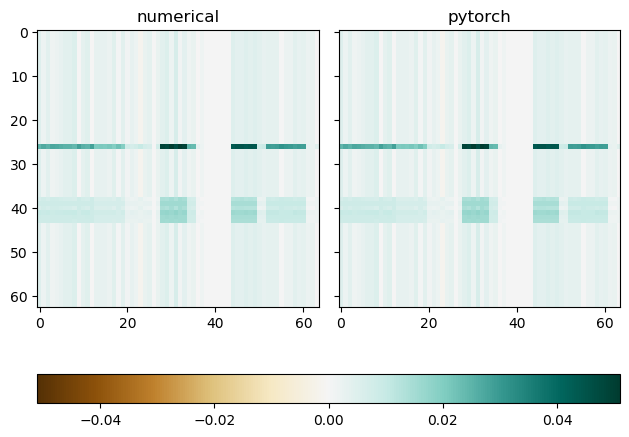

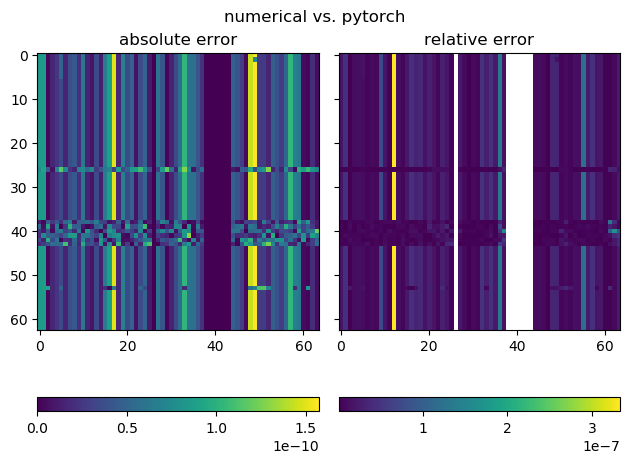

In [32]:

fig1, fig2 = reports.compare_matrices(
    (grad_num ,grad_pytorch), ('numerical', 'pytorch'))
fig2.show()
#fig2.savefig("pytorch_compare_1.png")
fig1.show()
#fig1.savefig("pytorch_compare_2.png") 
plt.show()


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


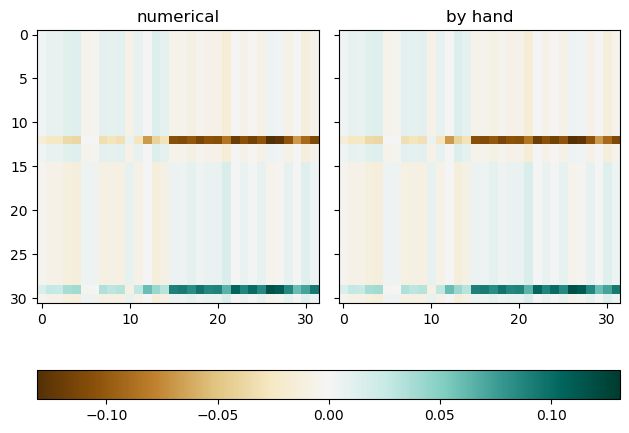

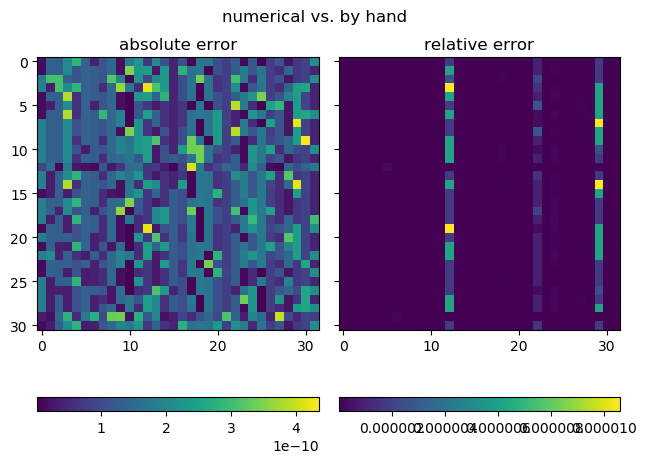

In [73]:
fig3, fig4 = reports.compare_matrices(
    (grad_num, grad_hand), ('numerical', 'by hand',))
fig3.show()
fig4.show()
plt.show()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


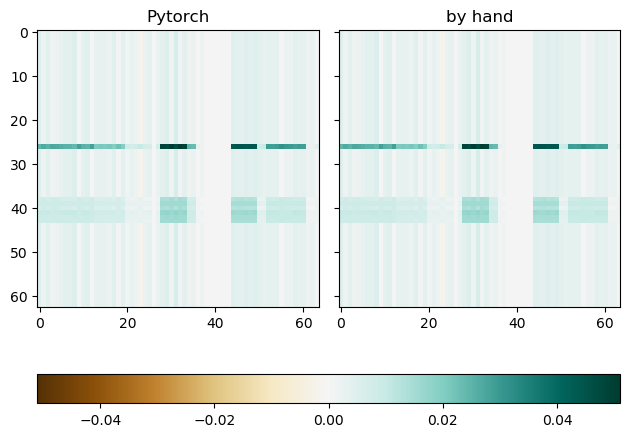

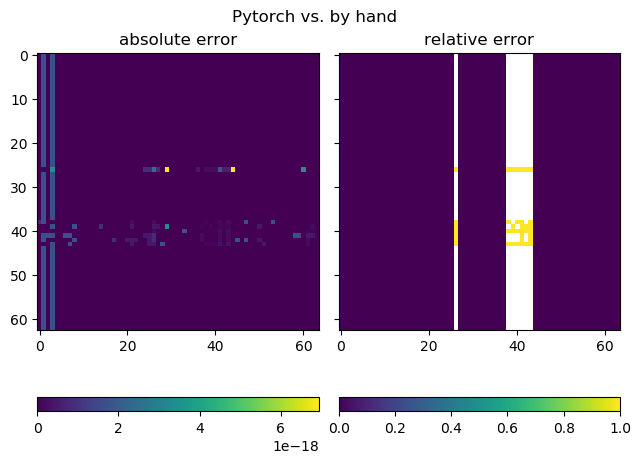

In [33]:
fig5, fig6 = reports.compare_matrices(
    (grad_pytorch, grad_hand), ('Pytorch', 'by hand',))

fig5.show()
fig6.show()
plt.show()

In [12]:

# timing
prob = opt.make_cvxpy_problem(A, k)
prob.y.value = y
prob.W.value = W

time_hand = repeat(lambda: hand_grad(prob, y, W, x), number=100)
time_cvxpy = repeat(lambda: cvxpy_grad(prob, x), number=100)
time_pytorch = repeat(lambda: pytorch_grad(prob, y, W, x), number=100)

print('time by hand:')
print(min(time_hand))

print('time by pytorch')
print(min(time_pytorch)) 

print('time by cvxpy:')
print(min(time_cvxpy))

time by hand:
1.1823193000000174
time by pytorch
1.3433403000008184
time by cvxpy:
2.0213777999997546


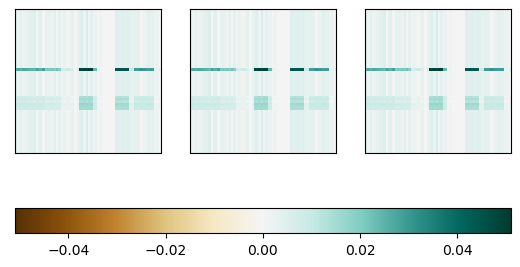

In [34]:

#fig1, fig2,fig3 = reports.plot_all((grad_hand,grad_cvxpy,grad_pytorch), ('by closed form ','by cvxpy','by pytorch'))
x1=grad_hand
x2=grad_cvxpy
x3= grad_pytorch
x4 = grad_num
titles = ('By BLORC ','By CVXPY','By PyTorch')
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True)
ax = axes[0] # useful later for sharing axes
args = dict(vmin=-np.max(np.abs((x1, x2,x3))),
            vmax=np.max(np.abs((x1, x2,x3))),
            cmap='BrBG',
            )
#plt.title('Gradient of upper level \n wrt W')
plt.xticks([])
plt.yticks([])
ax = axes[0]
im1 = axes[0].imshow(x1.copy(), **args)
#axes[0].set_title(titles[0],fontsize=16)
im2 = axes[1].imshow(x2.copy(), **args)
#axes[1].set_title(titles[1],fontsize=16)
im3 = axes[2].imshow(x3.copy(), **args)
#axes[2].set_title(titles[2],fontsize=16)
#fig.tight_layout()
fig.colorbar(im3, ax=axes, location='bottom')
#fig.title('Gradient of upper level \n wrt W')
plt.savefig("Gradients_dct.png")
plt.show()


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


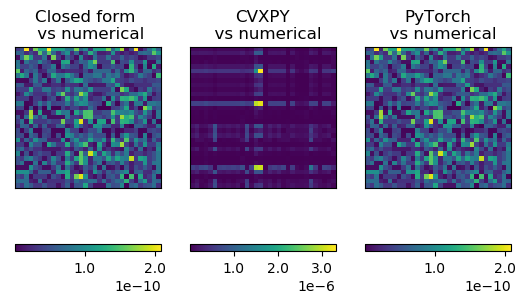

In [74]:

import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format





#opts = {location='bottom'}
fig1, axes1 = plt.subplots(1, 3, sharey=True, sharex=True)
im1 = axes1[0].imshow(np.abs(x1 - x4))
axes1[0].set_title('Closed form \n vs numerical')
plt.xticks([])
plt.yticks([])
fig.colorbar(im1,ax=axes1[0],fraction=0.2,orientation="horizontal",format=OOMFormatter(-10, mathText=False))

im2 = axes1[1].imshow(np.abs(x2 - x4))
axes1[1].set_title('CVXPY\n  vs numerical')
fig.colorbar(im2,ax=axes1[1],fraction=0.2,orientation="horizontal",format=OOMFormatter(-6, mathText=False))

im3 = axes1[2].imshow(np.abs(x3 - x4))
axes1[2].set_title('PyTorch\n  vs numerical')
fig.colorbar(im3,ax=axes1[2],fraction=0.2,orientation="horizontal",format=OOMFormatter(-10, mathText=False))
fig.tight_layout(pad=2)
#plt.save('Comparisions.png')
plt.savefig("Comparisions.png")
plt.show()